<p style="font-family:Times New Roman; font-size:120%">
    -Aleksander Nistad Sekkelsten
</p>
<h1 style="font-family:Times New Roman; font-size: 300%"><center>  Project 2 MNIST  data-Set</center></h1>

<p style="font-family:Times New Roman; font-size:120%">
    Here, analyze the MNIST dataset. I do very little tuning on the data, and then do a manual back-prop. code, zygote gradient code, and a flux model on the dataset. I do this for a FFNN and logistic regression and compare. Everything with SGD.
</p>

In [8]:
import Pkg; Pkg.activate(".julia/environments/v1.10/Project.toml")
Pkg.add("MLDataUtils")
using CSV, DataFrames, Flux, Random, Statistics, MLDataUtils, Plots, Optimisers, NBInclude, Zygote,MLDatasets,Images
@nbinclude("FYS-STK 4155 Project 2 Methods .ipynb")
@nbinclude("FYS-STK 4155 Project 2 FFNN.ipynb")

  Activating project at `~/.julia/environments/v1.10`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


ConfusionMatrix (generic function with 2 methods)

In [9]:
# Load MNIST dataset
xtrain, train_y = MNIST.traindata()  # 60,000 training samples
xtest, test_y = MNIST.testdata()     # 10,000 test samples

# Normalize the data to the range [0, 1]
train_X = Float32.(xtrain) ./ 255.0
test_X = Float32.(xtest) ./ 255.0

# Reshape the data into a 2D format (28x28 images to 784 features)
train_X = reshape(train_X, 28 * 28, 60_000)
test_X = reshape(test_X, 28 * 28, 10_000)

# Convert labels to one-hot encoded vectors
function one_hot_encoding(labels, num_classes)
    return Flux.onehotbatch(labels, 0:num_classes-1)
end

train_y_onehot = one_hot_encoding(train_y, 10)
test_y_onehot = one_hot_encoding(test_y, 10)


┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets ~/.julia/packages/MLDatasets/0MkOE/src/datasets/vision/mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets ~/.julia/packages/MLDatasets/0MkOE/src/datasets/vision/mnist.jl:195


10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

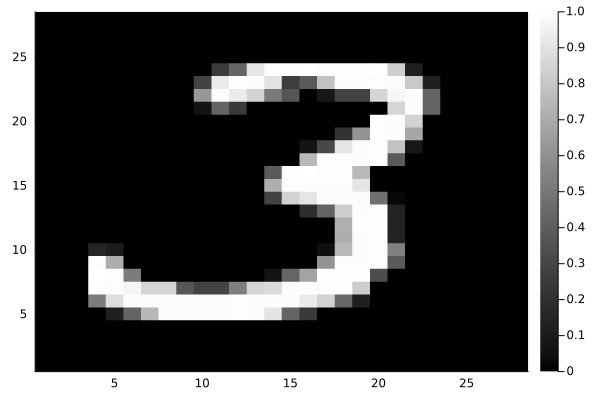

In [10]:
heatmap(rotl90(xtrain[:,:,282]),cmap=:greys) #Visualizing a random sample

In [11]:
function simple_accuracy(model, x,y)
    y_hat = model(x)
    iscorrect = Flux.onecold(y_hat) .== Flux.onecold(y)  # BitVector
    acc = round(100 * mean(iscorrect); digits=2)
end

simple_accuracy (generic function with 1 method)

In [12]:
Method = "FFNN"
input_dimension = 28^2
output_dimension = 10
epochs = 300
batch_size = 80
η = 1e-1

if Method=="FFNN"
    #FFNN
    outs = [64, output_dimension] # FFNN
    activation_functions = [Sigmoid,Softmax]
    model = Chain(
        Dense(input_dimension, 64, sigmoid),
        Dense(64, output_dimension),
        softmax# FFNN with hidden layer
    )
else
    #Logistic Regression
    model = Chain(
        Dense(input_dimension, 10), softmax
    )
    outs = [output_dimension]
    activation_functions = [Softmax]
end

Chain(
  Dense(784 => 64, σ),                  # 50_240 parameters
  Dense(64 => 10),                      # 650 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 50_890 parameters, 199.039 KiB.

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Flux</h2>


In [13]:
# Loss function: Binary cross-entropy
loss(y_pred, y_true) = Flux.Losses.crossentropy(y_pred, y_true)

# Optimizer: Adam optimizer
opt = Flux.setup(Flux.Descent(η),model) # Learning rate of 0.01
 
# Number of epochs and batch size
num_samples = size(train_X, 2)
num_batches = ceil(Int, num_samples / batch_size)

# Training loop
for epoch in 1:epochs
    for j in 1:num_batches
        # Batch indices
        a = batch_size * (j - 1) + 1
        b = min(batch_size * j, num_samples)

        # Get batch data
        input = train_X[:, a:b]
        label = train_y_onehot[:, a:b]

        # Compute gradients
        grads = gradient(m -> Flux.crossentropy(m(input), label), model)[1]
        # Update model parameters
        Flux.Optimise.update!(opt, model, grads)
    end

    # Print loss every 10 epochs
    if epoch % 50 == 0
        test_loss = Flux.crossentropy(model(test_X), test_y_onehot)
        println("Epoch $epoch Loss:  ", test_loss, " Accuracy : ", simple_accuracy(model, test_X,test_y_onehot))
    end
end

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(784 => 64, σ)  # 50_240 parameters
│   summary(x) = "784×80 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


Epoch 50 Loss:  2.2672396 Accuracy : 32.88
Epoch 100 Loss:  1.6898891 Accuracy : 53.3
Epoch 150 Loss:  1.0248528 Accuracy : 71.28
Epoch 200 Loss:  0.7457897 Accuracy : 79.28
Epoch 250 Loss:  0.6011727 Accuracy : 82.66
Epoch 300 Loss:  0.5204264 Accuracy : 84.89


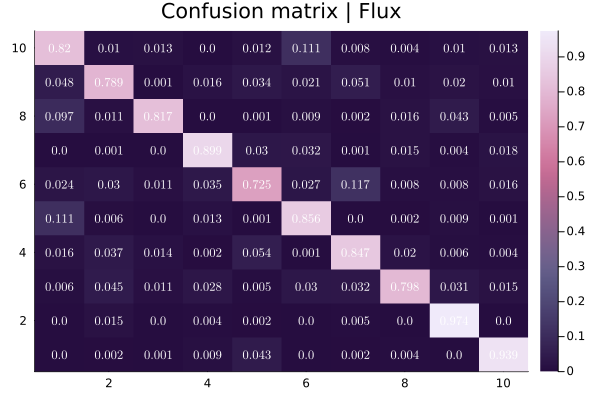

In [14]:
cm, labels = ConfusionMatrix(model,test_X,test_y_onehot) 
hFLUX = heatmap(cm, cmap=:acton,title="Confusion matrix | Flux")
annotate!(hFLUX,[(j, i, text(round(cm[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:10 for j in 1:10])
display(hFLUX)

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Manual Training, Zygote Gradient</h2>


In [15]:
xTrain = train_X'
xTest = test_X'

10000×784 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  

In [16]:
layers = create_layers_batch(input_dimension, outs)

2-element Vector{Any}:
 ([0.008055337328935548 0.07216161507871703 … 0.018456392018249744 0.04488135301448146; -0.019456631204745337 -0.03159689043742497 … -0.04455564830090716 -0.06847097922181958; … ; 0.04531476651002229 0.04140505724168355 … -0.036376703135220644 -0.004414395694816519; 0.0035267827690360983 -0.031508306568881636 … -0.00814431711180235 0.02196719590528673], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 ([0.1535655722178015 -0.018365341259677568 … 0.05819618401401749 0.02488905569714854; 0.06266630243363613 0.19319393101528537 … 0.2225958259910307 -0.036934413946440536; … ; 0.40340053042030793 -0.15108626334825156 … 0.15596821534011662 -0.05087094573270906; -0.026908613239059718 0.051001496602249 … 0.05008011234051424 0.16871976754560533], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [17]:
function simple_accuracyManual(x, layers, activation_funcs, y)
    pred = transpose(feed_forward_batched(layers,x , activation_functions;backprop=false))
    iscorrect = Flux.onecold(pred) .== Flux.onecold(y)  # BitVector
    acc = round(100 * mean(iscorrect); digits=2)
end
function trainer!(x_train,y_train, x_test, y_test, layers, activation_funcs, learning_rate=0.01, epochs=1000; batch_size, optimizer, loss)
    num_batches=Int(round(length(y_train[1,:])/batch_size))
    batch_size=80
    params = initialize(optimizer, layers, learning_rate, num_batches,batch_size;γ=0.9)
    lossHistory = []
    
    for epoch in 1:epochs
        (layers, params) = optimizer(x_train, y_train, layers,  activation_funcs,loss, params)
        if epoch%20==0
            test_loss=loss(x_test, layers, activation_funcs, y_test)
            println("Epoch:  ", epoch, "  Loss: ", test_loss, " Accuracy : ", simple_accuracyManual(x_test, layers, activation_funcs, y_test))
            push!(lossHistory, test_loss)
        end
    end
    return layers, lossHistory
end


trainer! (generic function with 3 methods)

In [18]:
function CEL(x, layers, activation_funcs, y)
    pred = transpose(feed_forward_batched(layers,x , activation_functions;backprop=false))
    loss = Flux.crossentropy(pred, y)
    return loss
end

CEL (generic function with 1 method)

In [19]:
layers = create_layers_batch(input_dimension, outs)
trainer!(xTrain,train_y_onehot, xTest, test_y_onehot, layers, activation_functions, η, epochs; batch_size=batch_size, optimizer=SGD!, loss=CEL)

Epoch:  20  Loss: 2.2974896506719618 Accuracy : 9.83
Epoch:  40  Loss: 2.2825559484641875 Accuracy : 30.11
Epoch:  60  Loss: 2.222398645682398 Accuracy : 41.35
Epoch:  80  Loss: 2.021898978570342 Accuracy : 45.6
Epoch:  100  Loss: 1.6680607129744611 Accuracy : 54.12
Epoch:  120  Loss: 1.333683730394996 Accuracy : 62.35
Epoch:  140  Loss: 1.1012700882459268 Accuracy : 69.4
Epoch:  160  Loss: 0.9400085047121564 Accuracy : 74.53
Epoch:  180  Loss: 0.8195218659374294 Accuracy : 77.91
Epoch:  200  Loss: 0.7276767708378162 Accuracy : 80.08
Epoch:  220  Loss: 0.658336540882987 Accuracy : 81.61
Epoch:  240  Loss: 0.6061655482236862 Accuracy : 82.75
Epoch:  260  Loss: 0.5662175236203729 Accuracy : 83.78
Epoch:  280  Loss: 0.5347157904037477 Accuracy : 84.65
Epoch:  300  Loss: 0.5091563381776729 Accuracy : 85.34


(Any[([0.028497960134401142 -0.0015885618784662332 … -0.02095355964226072 0.03272958390255256; -0.05083975228262095 -0.022450091015779883 … -0.0006468779031116637 0.03078020437088577; … ; -0.010462936405172435 0.00213836183189359 … -0.026594435854433753 -0.02936974988659637; 0.03796181629259997 -0.017819792162070885 … -0.010757370149778702 -0.043615993427296204], [-0.0840910879913121, -0.07598575068162701, -0.037179191848206256, -0.017519114653018704, -0.0983547553851358, 0.0035526522206464663, -0.07335444517460474, -0.07433108478232586, 0.00010855816104837377, -0.08119221703382319  …  -0.049824129963909336, -0.03482539073010138, -0.028722232252636724, 0.0034670312642722185, -0.07798272702999405, 0.02999941706324203, 0.031609842841383615, -0.16258691429878896, 0.00379535507924973, -0.0037350935410926673]), ([-0.2671652367621308 -8.432742146061276 … 2.372016162743325 1.1351525779629128; -0.14088446025170914 -2.7094935921717216 … 2.5835588262302407 -6.094989674075421; … ; 1.9720133619231

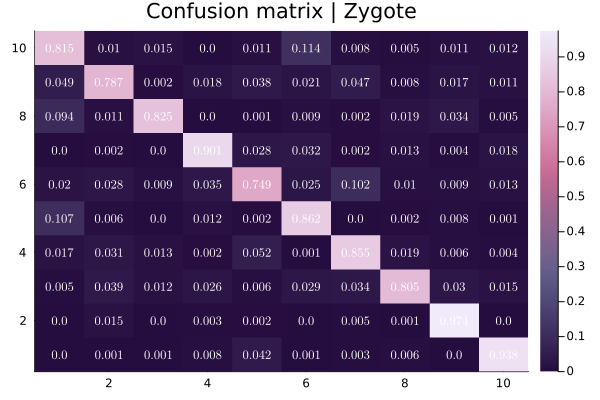

In [20]:

cm, labels = ConfusionMatrix(layers,xTest,test_y_onehot, activation_functions)
hZ = heatmap(cm, cmap=:acton,title="Confusion matrix | Zygote")
annotate!(hZ,[(j, i, text(round(cm[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:10 for j in 1:10])
display(hZ)

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Manual Training w/ manual Backprop</h2>


In [21]:
num_batches = Int(round(length(train_y_onehot[1,:])/batch_size))
layers = create_layers_batch(input_dimension, outs)
for i in 1:epochs
    for j in 1:num_batches
        # Get batch data
        input, label = batch(xTrain, train_y_onehot, num_batches, batch_size, j)
        
        output, backs = feed_forward_batched(layers, input, activation_functions; backprop=true)
        layers = BackwardsPropagation(layers, label, backs, activation_functions,η)
    end
    if i%10==0
        println("Epoch: $i Loss: ", CEL(xTest, layers, activation_functions, test_y_onehot), " Accuracy : ",  simple_accuracyManual(xTest, layers, activation_functions, test_y_onehot))
    end
end

Epoch: 10 Loss: 2.031210668925314 Accuracy : 52.87
Epoch: 20 Loss: 0.9660431071466148 Accuracy : 72.73
Epoch: 30 Loss: 0.6317197640092349 Accuracy : 81.16
Epoch: 40 Loss: 0.5172023183481119 Accuracy : 84.37
Epoch: 50 Loss: 0.4594253713782824 Accuracy : 86.21
Epoch: 60 Loss: 0.4243709828170404 Accuracy : 87.24
Epoch: 70 Loss: 0.400233920706512 Accuracy : 88.04
Epoch: 80 Loss: 0.38210428661660006 Accuracy : 88.63
Epoch: 90 Loss: 0.36784205558531713 Accuracy : 89.03
Epoch: 100 Loss: 0.3563609030230313 Accuracy : 89.38
Epoch: 110 Loss: 0.34699337328678526 Accuracy : 89.72
Epoch: 120 Loss: 0.3392693178608077 Accuracy : 90.07
Epoch: 130 Loss: 0.3328362888708371 Accuracy : 90.36
Epoch: 140 Loss: 0.32742541231050093 Accuracy : 90.57
Epoch: 150 Loss: 0.3228312898380066 Accuracy : 90.73
Epoch: 160 Loss: 0.31889692578910395 Accuracy : 90.8
Epoch: 170 Loss: 0.31550163743186177 Accuracy : 90.9
Epoch: 180 Loss: 0.31255157956137186 Accuracy : 90.94
Epoch: 190 Loss: 0.30997264284627746 Accuracy : 91.0

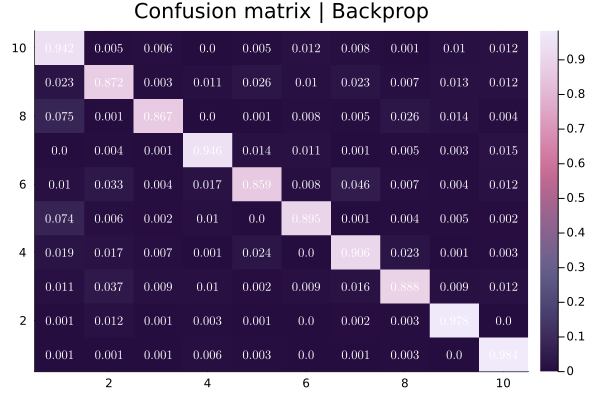

In [22]:
cm, labels = ConfusionMatrix(layers,xTest,test_y_onehot, activation_functions)
hB = heatmap(cm, cmap=:acton,title="Confusion matrix | Backprop")
annotate!(hB,[(j, i, text(round(cm[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:10 for j in 1:10])
display(hB)

In [23]:
Method = "LR"
input_dimension = 28^2
output_dimension = 10
epochs = 300
batch_size = 80
η = 1e-1

if Method=="FFNN"
    #FFNN
    outs = [64, output_dimension] # FFNN
    activation_functions = [Sigmoid,Softmax]
    model = Chain(
        Dense(input_dimension, 64, sigmoid),
        Dense(64, 10), softmax, # FFNN with hidden layer
    )
else
    #Logistic Regression
    # Define the neural network model
    model = Chain(
        Dense(input_dimension, 10), softmax 
    )
    outs = [output_dimension]
    activation_functions = [Softmax]
end

1-element Vector{typeof(Softmax)}:
 Softmax (generic function with 1 method)

In [24]:
# Loss function: Binary cross-entropy
loss(y_pred, y_true) = Flux.Losses.crossentropy(y_pred, y_true)

# Optimizer: Adam optimizer
opt = Flux.setup(Flux.Descent(η),model) # Learning rate of 0.01

# Number of epochs and batch size
num_samples = size(train_X, 2)
num_batches = ceil(Int, num_samples / batch_size)

# Training loop
for epoch in 1:epochs
    for j in 1:num_batches
        # Batch indices
        a = batch_size * (j - 1) + 1
        b = min(batch_size * j, num_samples)

        # Get batch data
        input = train_X[:, a:b]
        label = train_y_onehot[:, a:b]

        # Compute gradients
        grads = gradient(m -> Flux.crossentropy(m(input), label), model)[1]
        # Update model parameters
        Flux.Optimise.update!(opt, model, grads)
    end

    # Print loss every 10 epochs
    if epoch % 50 == 0
        test_loss = Flux.crossentropy(model(test_X), test_y_onehot)
        println("Epoch $epoch Loss:  ", test_loss, " Accuracy : ", simple_accuracy(model, test_X,test_y_onehot))
    end
end

Epoch 50 Loss:  2.237214 Accuracy : 40.54
Epoch 100 Loss:  2.1757627 Accuracy : 53.95
Epoch 150 Loss:  2.1168563 Accuracy : 60.88
Epoch 200 Loss:  2.060448 Accuracy : 65.22
Epoch 250 Loss:  2.0064816 Accuracy : 67.94
Epoch 300 Loss:  1.954891 Accuracy : 69.93


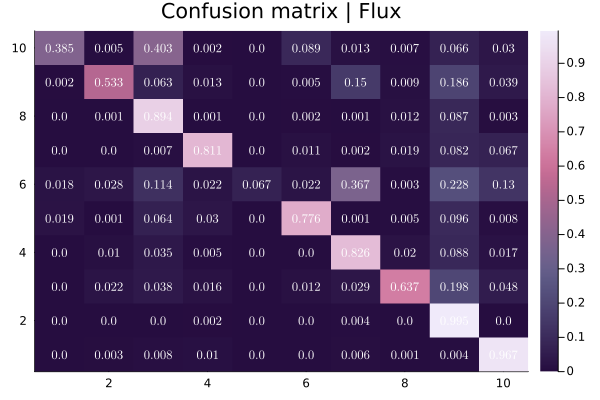

In [25]:
cm, labels = ConfusionMatrix(model,test_X,test_y_onehot)
hf = heatmap(cm, cmap=:acton,title="Confusion matrix | Flux")
annotate!(hf, [(j, i, text(round(cm[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:10 for j in 1:10])
display(hf)

In [26]:
layersLR = create_layers_batch(input_dimension, outs)
trainer!(xTrain,train_y_onehot, xTest, test_y_onehot, layersLR, activation_functions, η, epochs; batch_size=batch_size, optimizer=SGD!, loss=CEL)

Epoch:  20  Loss: 2.27579084990881 Accuracy : 23.17
Epoch:  40  Loss: 2.2502722042510106 Accuracy : 35.93
Epoch:  60  Loss: 2.2251679785710903 Accuracy : 44.43
Epoch:  80  Loss: 2.200476109236551 Accuracy : 49.97
Epoch:  100  Loss: 2.176194284786611 Accuracy : 54.04
Epoch:  120  Loss: 2.152319942968408 Accuracy : 57.24
Epoch:  140  Loss: 2.1288502696777556 Accuracy : 59.81
Epoch:  160  Loss: 2.105782199870995 Accuracy : 62.03
Epoch:  180  Loss: 2.0831124204713865 Accuracy : 64.07
Epoch:  200  Loss: 2.060837375249242 Accuracy : 65.26
Epoch:  220  Loss: 2.038953271611503 Accuracy : 66.45
Epoch:  240  Loss: 2.0174560891954285 Accuracy : 67.43
Epoch:  260  Loss: 1.996341590124218 Accuracy : 68.28
Epoch:  280  Loss: 1.9756053307510073 Accuracy : 69.29
Epoch:  300  Loss: 1.9552426746928853 Accuracy : 69.89


(Any[([-0.03024871417544484 -0.018127476473774246 … -0.05527399241034233 0.07635274364031733; 0.050717577600102856 -0.03383961750303495 … -0.08460077196265725 0.05679712432354117; … ; -0.011055811826771638 0.018754828710098193 … 0.03621925755985312 -0.039297609489251616; -0.03629214429789985 -0.05021296046419186 … -0.0029425470379729306 0.015029499596826687], [-0.21349519872423053, 0.4506090730754011, -0.07332109100081745, -0.04915197318489533, 0.054099544917426336, -0.042800069771331606, -0.06676549617389184, 0.1942730170430204, -0.21207132079797714, -0.041376485382709244])], Any[2.27579084990881, 2.2502722042510106, 2.2251679785710903, 2.200476109236551, 2.176194284786611, 2.152319942968408, 2.1288502696777556, 2.105782199870995, 2.0831124204713865, 2.060837375249242, 2.038953271611503, 2.0174560891954285, 1.996341590124218, 1.9756053307510073, 1.9552426746928853])

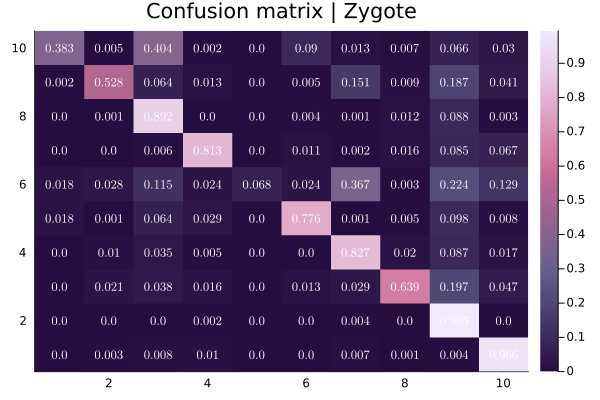

In [27]:
cm, labels = ConfusionMatrix(layersLR,xTest,test_y_onehot, activation_functions)
hz = heatmap(cm, cmap=:acton,title="Confusion matrix | Zygote")
annotate!(hz, [(j, i, text(round(cm[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:10 for j in 1:10])
display(hz)

In [28]:
num_batches = Int(round(length(train_y_onehot[1,:])/batch_size))
layers = create_layers_batch(input_dimension, outs)
for i in 1:epochs
    for j in 1:num_batches
        # Get batch data
        input, label = batch(xTrain, train_y_onehot, num_batches, batch_size, j)
        
        output, backs = feed_forward_batched(layers, input, activation_functions; backprop=true)
        layers = BackwardsPropagation(layers, label, backs, activation_functions,η)
    end
    if i%20==0
        println("Epoch: $i Loss: ", CEL(xTest, layers, activation_functions, test_y_onehot), " Accuracy : ",  simple_accuracyManual(xTest, layers, activation_functions, test_y_onehot))
    end
end

Epoch: 20 Loss: 2.105810183782728 Accuracy : 62.03
Epoch: 40 Loss: 1.9353101950611635 Accuracy : 70.66
Epoch: 60 Loss: 1.7880301266330407 Accuracy : 74.28
Epoch: 80 Loss: 1.6612113154913895 Accuracy : 76.28
Epoch: 100 Loss: 1.5519597333522313 Accuracy : 77.75
Epoch: 120 Loss: 1.4575691480325261 Accuracy : 78.91
Epoch: 140 Loss: 1.375664807311735 Accuracy : 79.62
Epoch: 160 Loss: 1.3042314567273143 Accuracy : 80.26
Epoch: 180 Loss: 1.2415881843401546 Accuracy : 80.96
Epoch: 200 Loss: 1.186344887863259 Accuracy : 81.4
Epoch: 220 Loss: 1.1373560695939833 Accuracy : 81.93
Epoch: 240 Loss: 1.0936782688202646 Accuracy : 82.35
Epoch: 260 Loss: 1.0545332437561443 Accuracy : 82.66
Epoch: 280 Loss: 1.0192771818797066 Accuracy : 82.97
Epoch: 300 Loss: 0.9873754497967371 Accuracy : 83.21


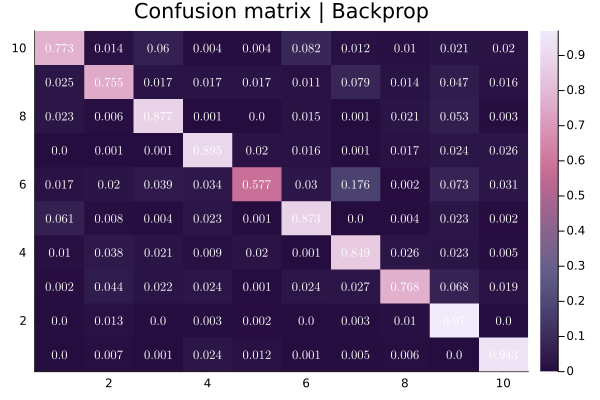

In [29]:
cm, labels = ConfusionMatrix(layers,xTest,test_y_onehot, activation_functions)
hb = heatmap(cm, cmap=:acton,title="Confusion matrix | Backprop")
annotate!(hb,[(j, i, text(round(cm[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:10 for j in 1:10])
display(hb)